In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import xgboost as xgb
from xgboost import plot_importance, plot_tree

import utility_functions as fn

In [2]:
weather = pd.read_csv('weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')

In [3]:
energy = pd.read_csv('energy_clean.csv',index_col=0)
energy.index = pd.to_datetime(energy.index,format='%Y-%m-%d %H:00:00')

energy['Yale_kWh'] = energy['YUAG']+energy['Berkeley']+energy['Hopper']+energy['17HH']
energy = pd.DataFrame(energy['Yale_kWh'])

In [4]:
split_date = '2018-07-20 00:00:00'
train = energy.loc[energy.index <= split_date].copy()
test = energy.loc[energy.index > split_date].copy()

In [5]:
def add_date_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [6]:
X_train, y_train = add_date_features(train, label='Yale_kWh')
X_test, y_test = add_date_features(test, label='Yale_kWh')

In [15]:
y_test

2018-07-20 01:00:00    394.2
2018-07-20 02:00:00    343.7
2018-07-20 03:00:00    364.8
2018-07-20 04:00:00    351.4
2018-07-20 05:00:00    362.1
2018-07-20 06:00:00    345.7
2018-07-20 07:00:00    395.4
2018-07-20 08:00:00    426.6
2018-07-20 09:00:00    530.4
2018-07-20 10:00:00    588.5
2018-07-20 11:00:00    647.6
2018-07-20 12:00:00    616.5
2018-07-20 13:00:00    656.8
2018-07-20 14:00:00    639.3
2018-07-20 15:00:00    675.7
2018-07-20 16:00:00    637.7
2018-07-20 17:00:00    653.1
2018-07-20 18:00:00    599.0
2018-07-20 19:00:00    569.9
2018-07-20 20:00:00    439.8
2018-07-20 21:00:00    440.1
2018-07-20 22:00:00    383.0
2018-07-20 23:00:00    399.7
2018-07-21 00:00:00    364.8
2018-07-21 01:00:00    373.7
2018-07-21 02:00:00    330.9
2018-07-21 03:00:00    366.9
2018-07-21 04:00:00    366.3
2018-07-21 05:00:00    361.4
2018-07-21 06:00:00    343.9
                       ...  
2018-07-26 18:00:00    626.9
2018-07-26 19:00:00    599.9
2018-07-26 20:00:00    518.7
2018-07-26 21:

In [8]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

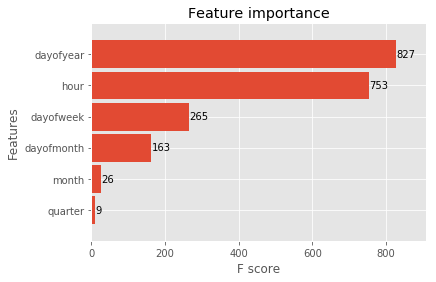

In [9]:
_ = plot_importance(reg, height=0.9)

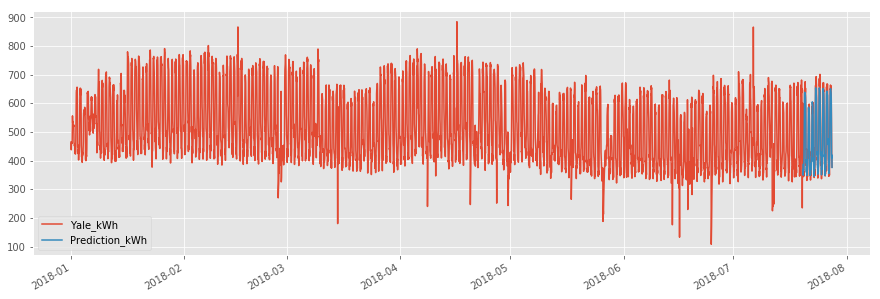

In [10]:
test['Prediction_kWh'] = reg.predict(X_test)
yale_all = pd.concat([test, train], sort=False)
_ = yale_all[['Yale_kWh','Prediction_kWh']].plot(figsize=(15, 5))

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
mean_absolute_percentage_error(y_true=test['Yale_kWh'], y_pred=test['Prediction_kWh'])

3.641461267578415